## Self Organizing Systems Assignment @ TU Vienna, WS2022
### Assignment: Attribute_Distribution
__Authors:__
* Florian Dedov, 11913611
* Julia Klint, 12205492
* Johannes knopp, 11909869

## Implementation

In [54]:
import numpy as np
import pandas as pdcoding
from SOMToolBox_Parse import SOMToolBox_Parse

In [55]:
import matplotlib.pyplot as plt
import matplotlib.cm
import matplotlib.pylab as pl
import matplotlib.patches as mpatches
import seaborn as sns
import ChernoffFace
import math


class SomAttributeDistributions:
    """
    A class to visualize SOMs on a per-unit basis


    Attributes
    ----------
    full_data : numpy.array
        full weight vector of the SOM
    data : numpy.array
        current selection of attributes to use for visualizations, equal to full_data by default
    names : list(str)
        names of the attributes in the SOM
    idx_used : list(int)
        indices of current selection of attributes used for visualizations
    _m : int
        first dimension of SOM
    _n : int
        second dimension of SOM

    Methods
    -------
    select_attributes(names)
        specify the attributes which will be used for visualizations.
        attributes must be identified by the names assigned at object creation.
    bar_chart()
        plot a (_m x _n) grid of bar charts, with each bar chart representing one unit and its weight vector.
    line_plot()
        plot a line for each attribute in the SOM.
        each attribute is sorted internally before plotting, to mimic a cumulative distribution function.
    box_plot()
        plot a box plot for each attribute in the SOM.
        each box plot represents the distribution of its representative in the weight vectors of the units.
    chernoff_faces()
        plot a (_m x _n) grid of chernoff faces, with each face representing one unit and its weight vector.
        each attribute corresponds to one facial feature of the faces.
    radar_chart()
        plot a radar chart for the attributes in the SOM.
        the radar chart represents the tendency of the attributes in the weight vectors of the units.
    violin_plot()
        plot a violin plot for each attribute in the SOM.
        each violin plot represents the distribution of its representative in the weight vectors of the units.
    """

    def __init__(self, weights, names, _m, _n):
        """
        Parameters
        ----------
        weights : numpy.array
            the weights vectors of the SOM. the expected shape of the weights object is (number of units, number of attributes)
        names : list(str)
            the names for the attributes of the SOM, these names will be used for selecting which attributes to plot as well as for identification in the plots themselves
        _m : int
            number of rows of the SOM, used for accurately visualizing grids
        _n : int
            number of columns of the SOM, used for accurately visualizing grids.
            _m * _n must sum up to the number of units
        """
        assert len(names) == weights.shape[1]
        self.full_data = weights
        self.data = weights
        self.names = names
        self.idx_used = list(range(len(names)))
        self._m = _m
        self._n = _n

    def _colors(self):
        """"
        used to dynamically assign colors depending on the number of attributes to visualize
        """
        return pl.cm.jet(np.linspace(0, 1, self.data.shape[1]))

    def select_attributes(self, names):
        """
        select which attributes to use

        Parameters
        ----------
        names : list(str)
            select which attributes to use for further visualizations. choose attributes by the names specified at object creation
        """
        assert all(i in self.names for i in names), 'selected attributes not in names'
        self.idx_used = [self.names.index(name) for name in names]
        self.data = np.array([self.full_data.T[i] for i in self.idx_used]).T

    def bar_chart(self, figsize=(18, 16)):
        """
        plots a grid of bar charts, with each bar chart representing one unit

        Parameters
        ----------
        figsize : tuple(int)
            specify size of the plot
        """
        fig, ax = plt.subplots(self._m, self._n, figsize=figsize)
        colors = self._colors()

        for i in range(self._m):
            for j in range(self._n):
                ax[i, j].bar(range(self.data.shape[1]), self.data[i * self._n + j, :], color=colors)
                ax[i, j].set_ylim((self.data.min(), self.data.max()+1))

        patches = [mpatches.Patch(color=colors[i], label=self.names[self.idx_used[i]]) for i in range(len(self.idx_used))]
        fig.legend(handles=patches, loc='center right')

    def line_plot(self):
        """
        plots one line per attribute, showing something akin to a cumulative distribution per attribute
        """
        sns.lineplot(data=np.sort(self.data.T).T)
        plt.legend(labels=[self.names[i] for i in self.idx_used])
        plt.show()

    def box_plot(self):
        """
        plots a box plot per attribute
        """
        fig = sns.boxplot(data=[self.data[i, :] for i in range(self.data.shape[1])])
        fig.set_xticklabels([self.names[i] for i in self.idx_used])

    def chernoff_faces(self, figsize=(15, 15)):
        """
        plots a grid of chernoff faces, with each grid representing one unit of the SOM

        Parameters
        ----------
        figsize : tuple(int)
            specify size of the plot
        """
        fig = ChernoffFace.chernoff_face(
            data=self.data,
            color_mapper=matplotlib.cm.Pastel1,
            titles=[f'{i},{j}' for i in range(self._m) for  j in range(self._n)],
            figsize=figsize,
            n_rows=self._m,
            n_columns=self._n
        )
        fig.tight_layout()
        plt.show()

    def radar_chart(self):
        """
        plots a radar chart for the tendencies of the attributes in the SOM
        """
        df = pdcoding.DataFrame({'group': [f'obsv{i}' for i in range(self.data.shape[0])]})
        for i in range(self.data.shape[1]):
            df[f'{self.names[self.idx_used[i]]}'] = self.data[:, i]

        categories = list(df)[1:]
        N = len(categories)

        values = df.loc[0].drop('group').values.flatten().tolist()
        values += values[:1]

        angles = [n / float(N) * 2 * math.pi for n in range(N)]
        angles += angles[:1]

        ax = plt.subplot(111, polar=True)

        plt.xticks(angles[:-1], categories, color='grey', size=8)

        ax.set_rlabel_position(0)
        ax.plot(angles, values, linewidth=1, linestyle='solid')
        ax.fill(angles, values, 'b', alpha=0.1)

        plt.show()

    def violin_plot(self):
        """
        plots a violin plot for each attribute of the SOM
        """
        fig = sns.violinplot(data=[self.data[i, :] for i in range(self.data.shape[1])])
        fig.set_xticklabels([self.names[i] for i in self.idx_used])


## Visualizations
### Iris data set, (10 x 10) SOM

In [56]:
idata_iris = SOMToolBox_Parse("datasets\\iris\\iris.vec").read_weight_file()
weights_iris = SOMToolBox_Parse("datasets\\iris\\iris.wgt.gz").read_weight_file()

Creating an instance of the SomAttributeDistributions class with the Iris attributes

In [57]:
vis_iris = SomAttributeDistributions(weights_iris['arr'], ['sep_length', 'sep_width', 'pet_length', 'pet_width'], weights_iris['xdim'], weights_iris['ydim'])

Selecting attributes by writing the names of the desired attributes

In [58]:
vis_iris.select_attributes(['sep_width', 'pet_width', 'pet_length'])

Bar chart: Visualizing the values of the attributes in each unit

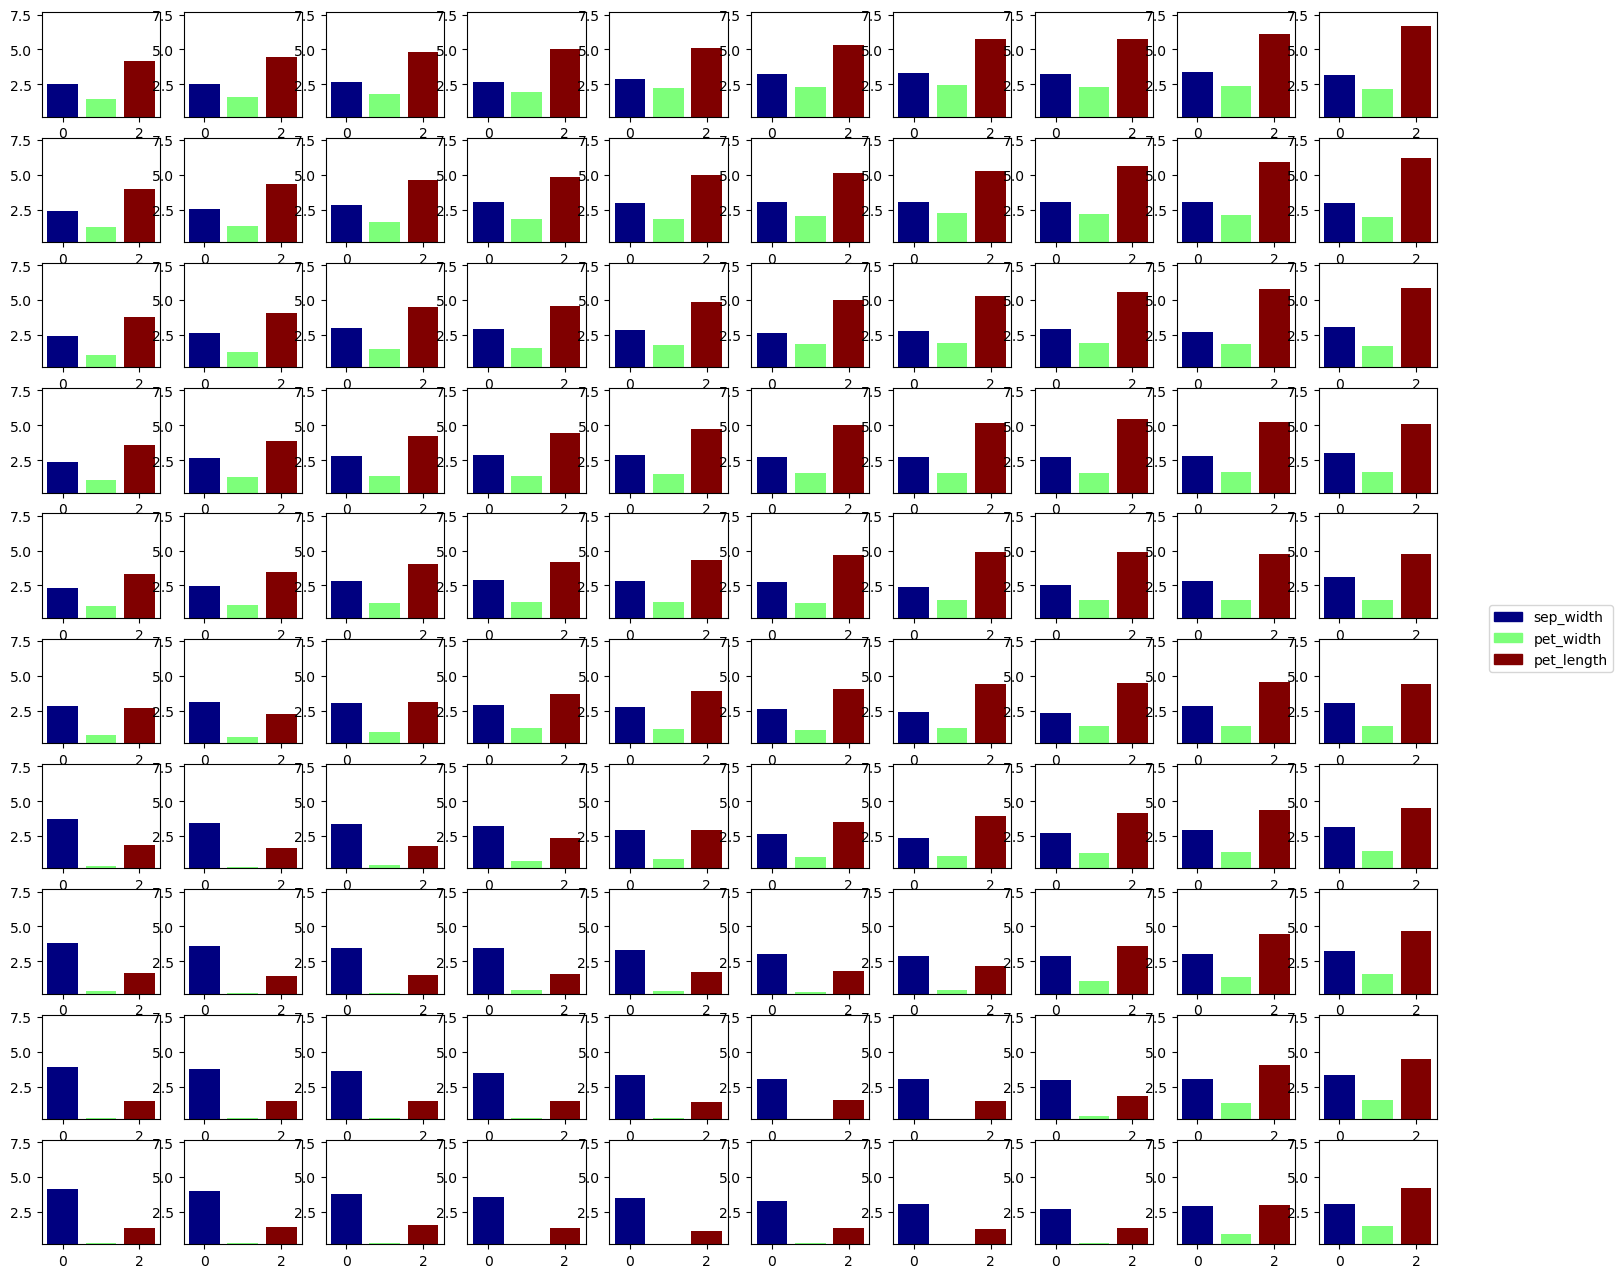

In [59]:
vis_iris.bar_chart()

Line plot: Visualizing the values of the attributes as lines in a sorted manner

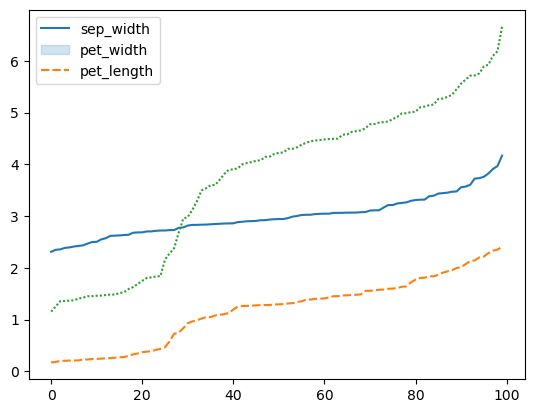

In [60]:
vis_iris.line_plot()

Chernoff faces: Visualizing different characteristics of the units and identifying clusters

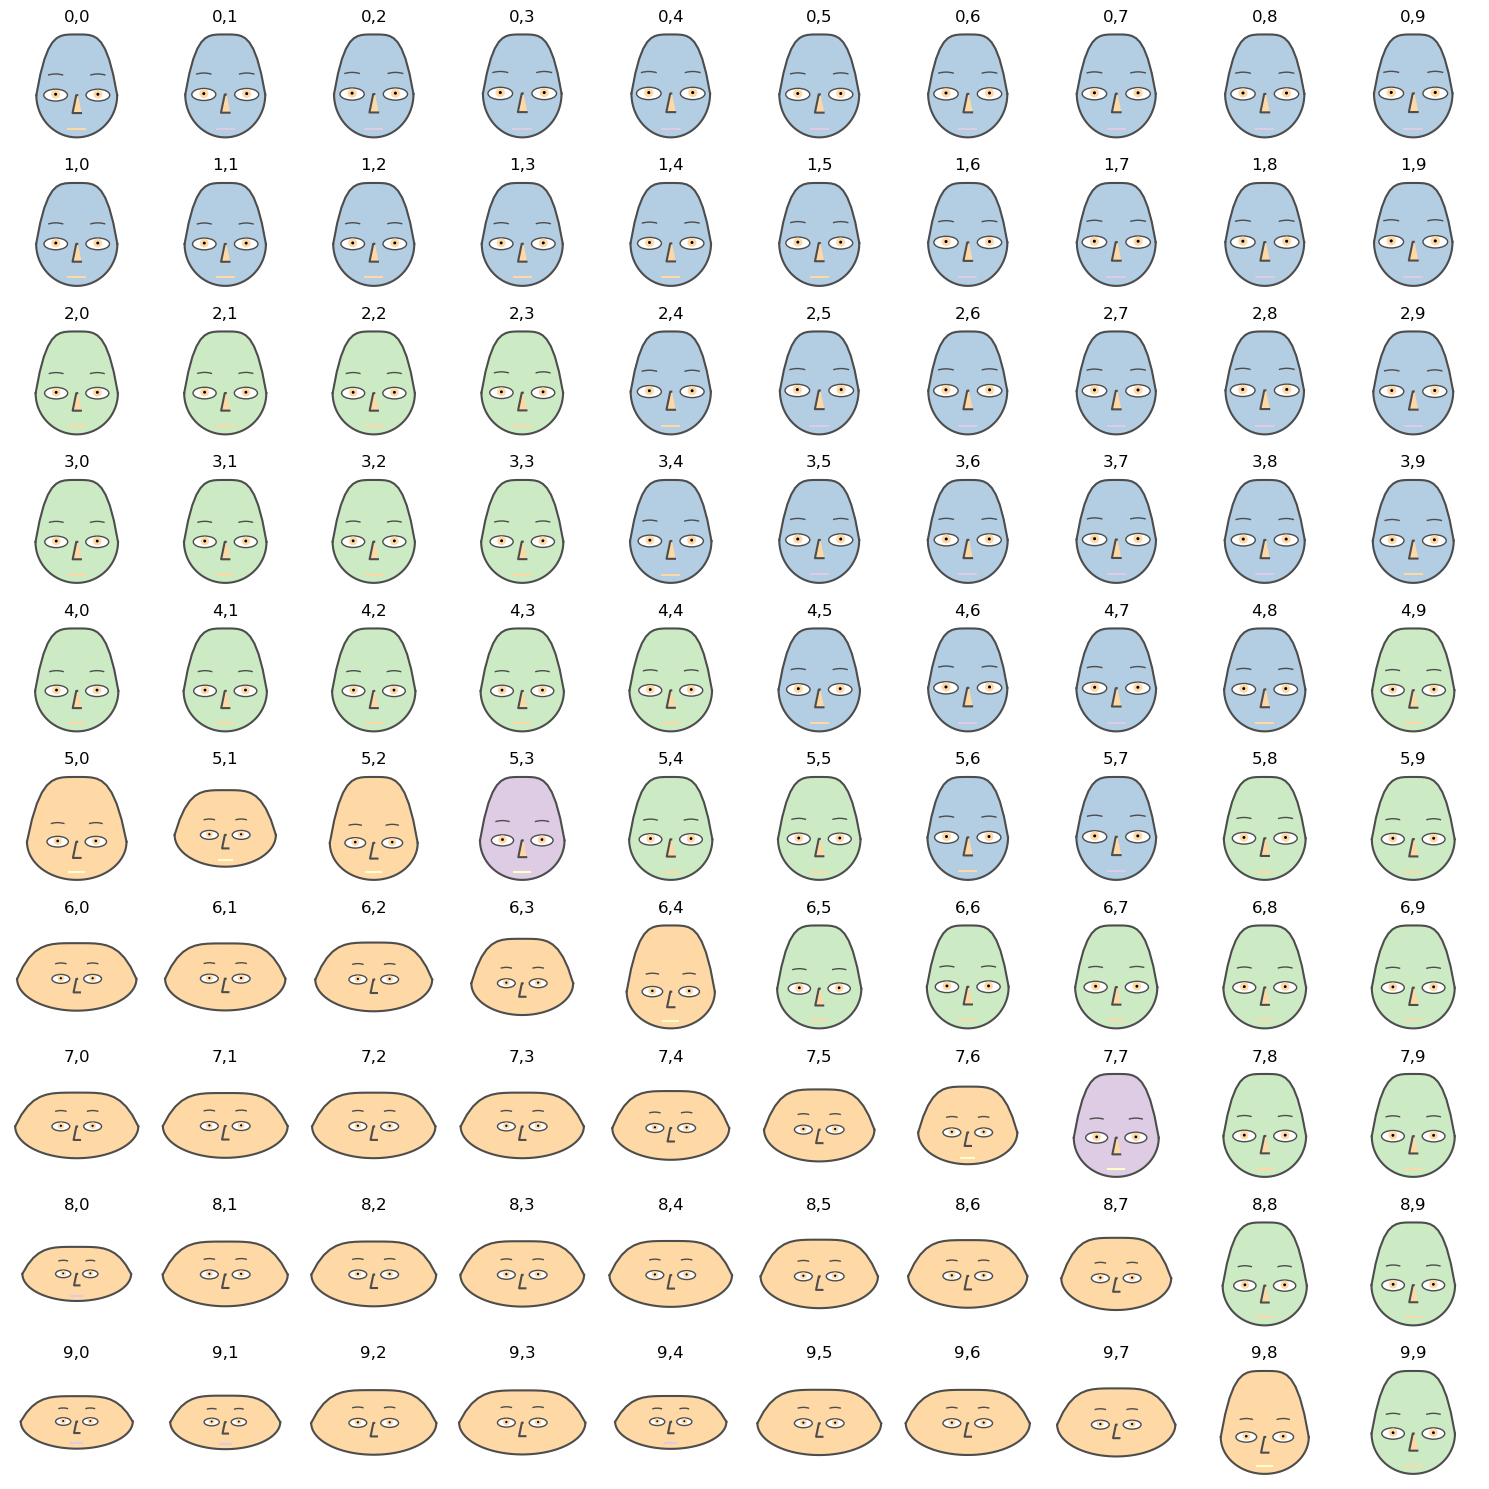

In [61]:
vis_iris.chernoff_faces()

Radar chart: Visualizing the maximum values of each attribute

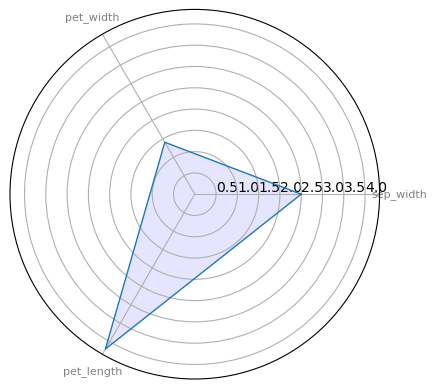

In [62]:
vis_iris.radar_chart()

Box plot: Visualizing the distribution of the attribute values

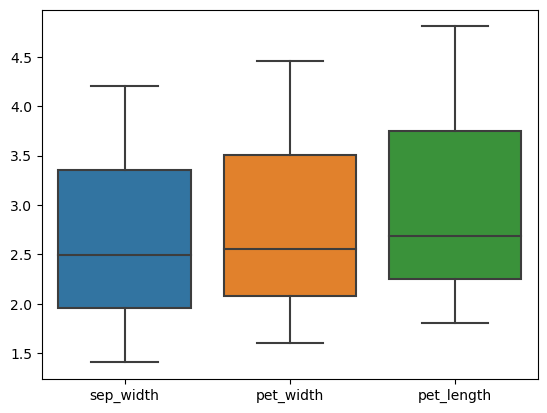

In [63]:
vis_iris.box_plot()

Violin plot: Visualizing the distribution of the attribute values

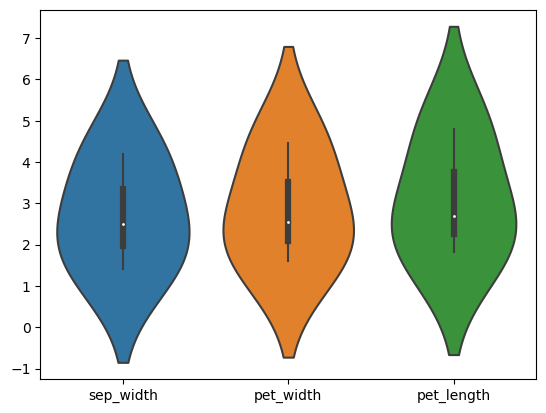

In [64]:
vis_iris.violin_plot()

### 10clusters data set, (10 x 10) SOM

In [65]:
idata_clusters = SOMToolBox_Parse("datasets\\10clusters\\10clusters.vec").read_weight_file()
weights_clusters = SOMToolBox_Parse("datasets\\10clusters\\10clusters.wgt.gz").read_weight_file()

In [66]:
vis_clusters = SomAttributeDistributions(weights_clusters['arr'], [f'comp_{i}' for i in range(1, 11)], weights_clusters['xdim'], weights_clusters['ydim'])

In [67]:
vis_clusters.select_attributes(['comp_1', 'comp_5', 'comp_10'])

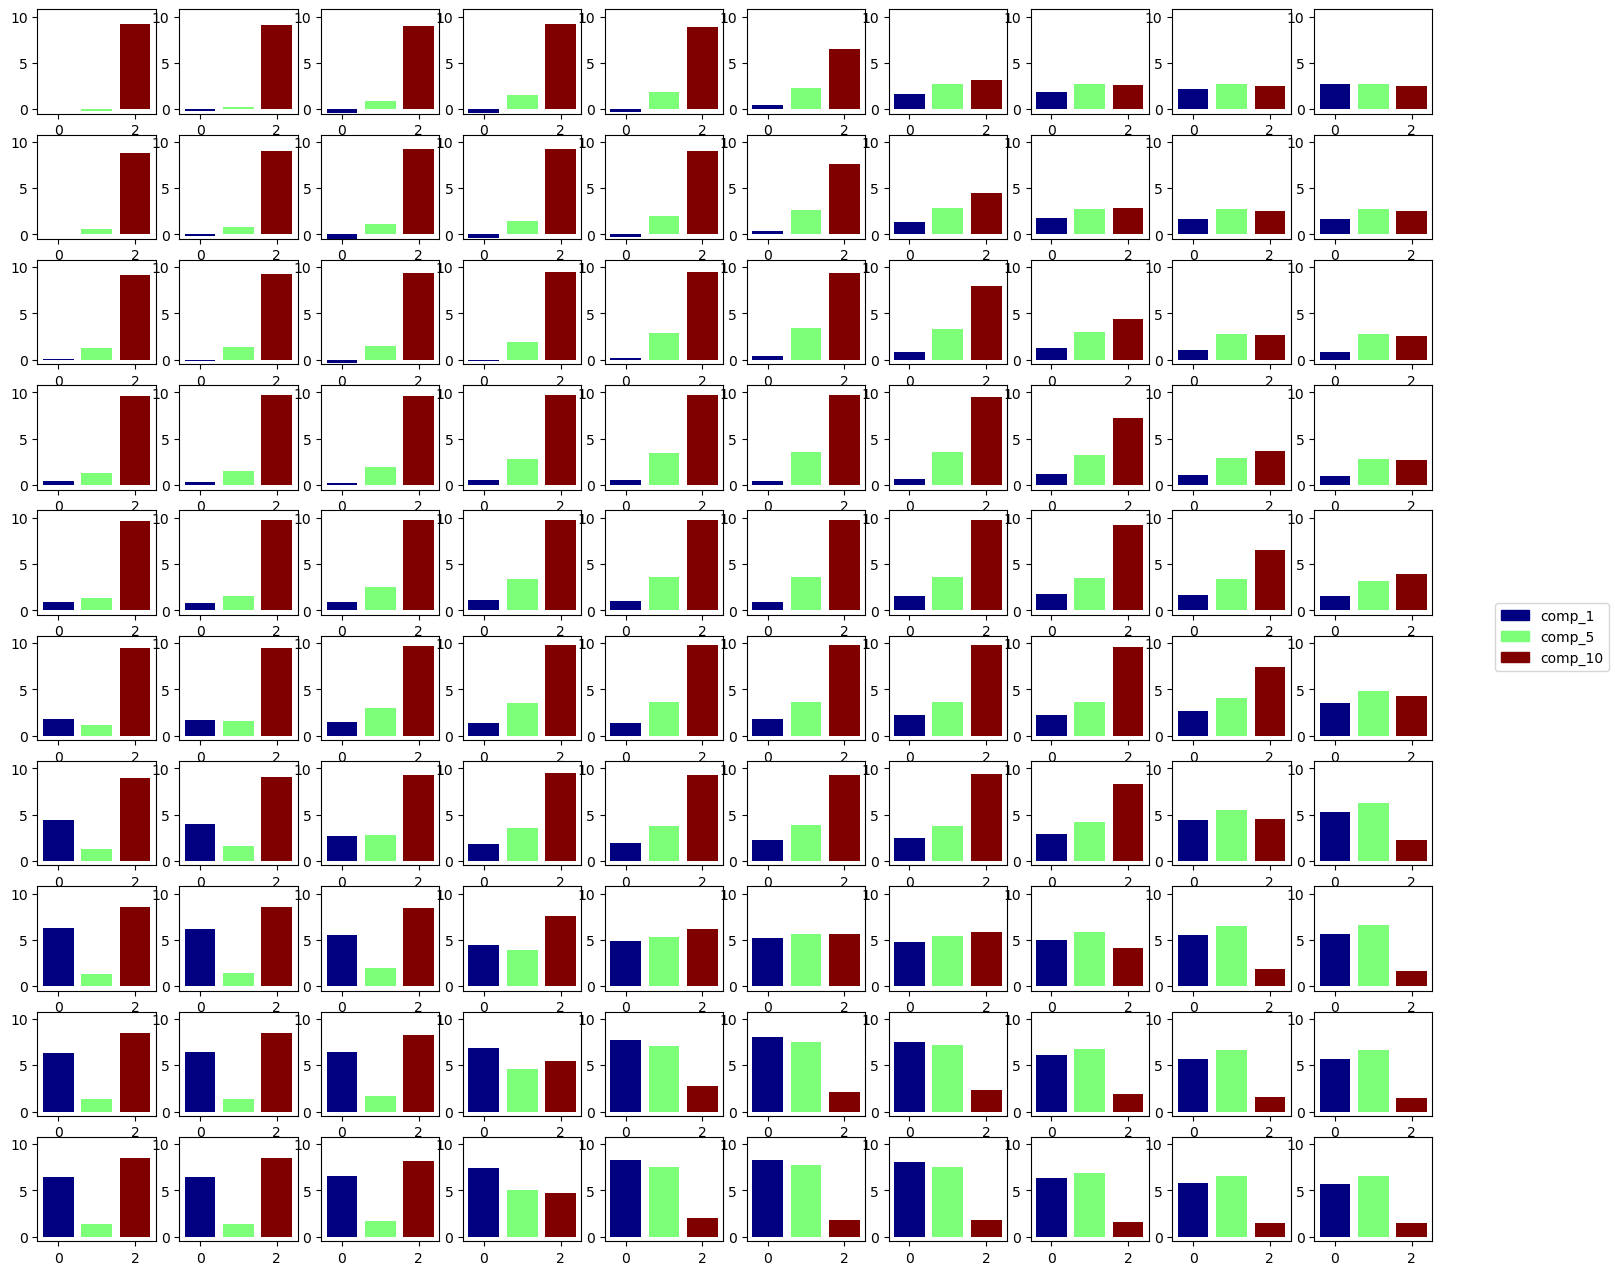

In [68]:
vis_clusters.bar_chart()

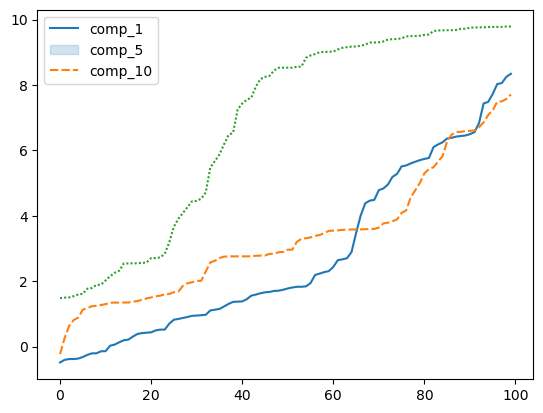

In [69]:
vis_clusters.line_plot()

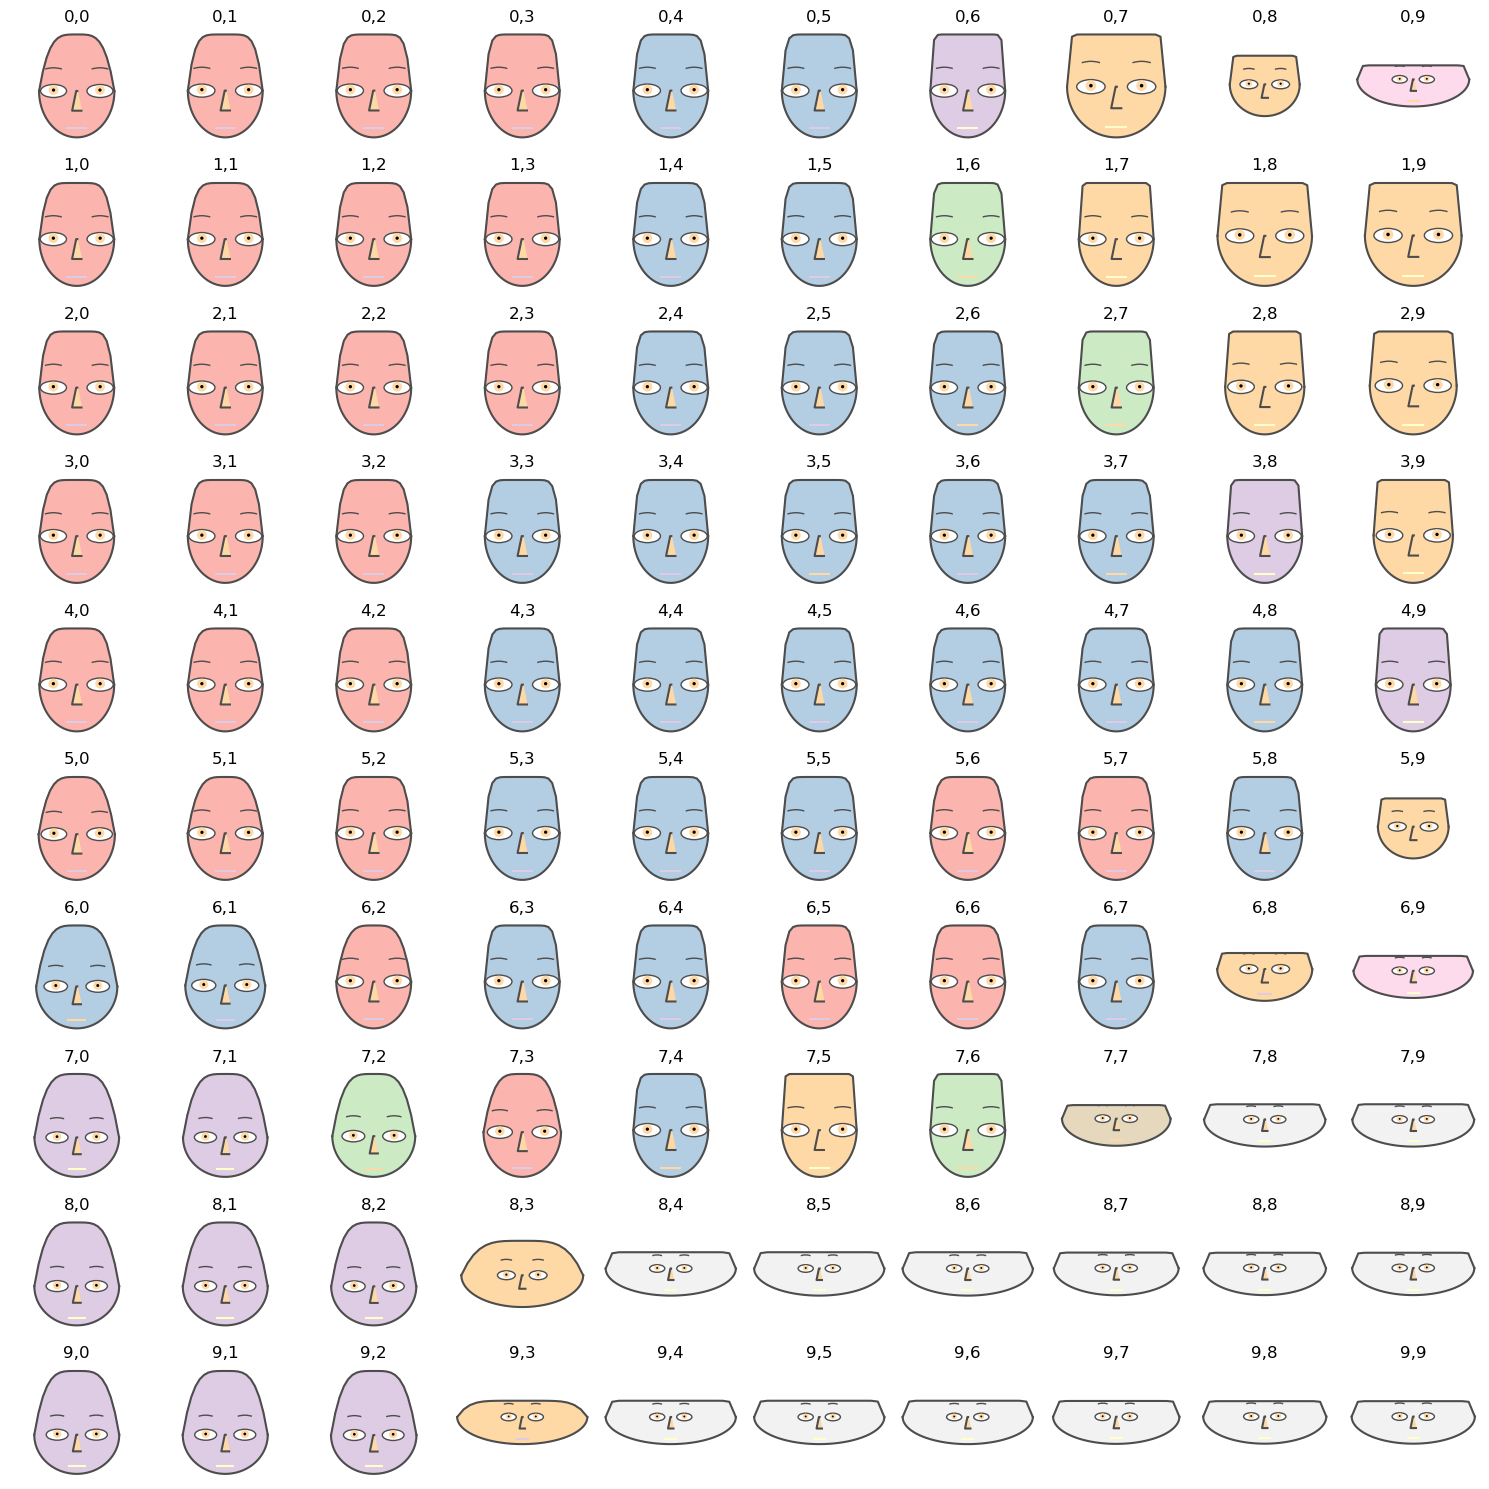

In [70]:
vis_clusters.chernoff_faces()

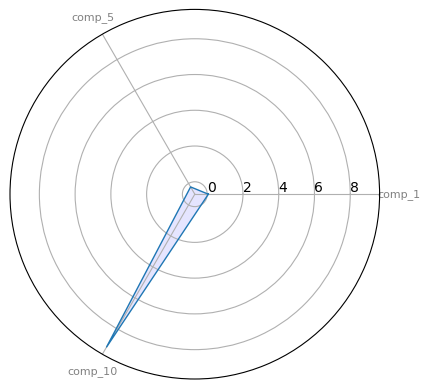

In [71]:
vis_clusters.radar_chart()

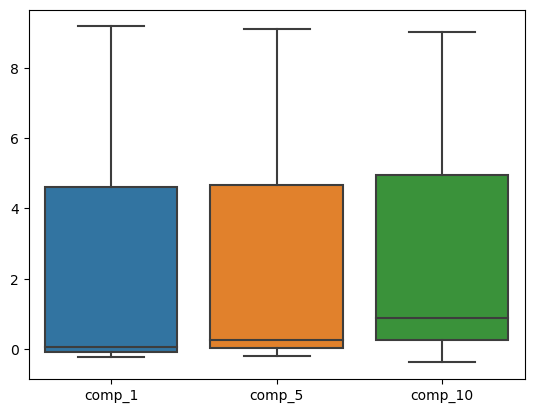

In [72]:
vis_clusters.box_plot()

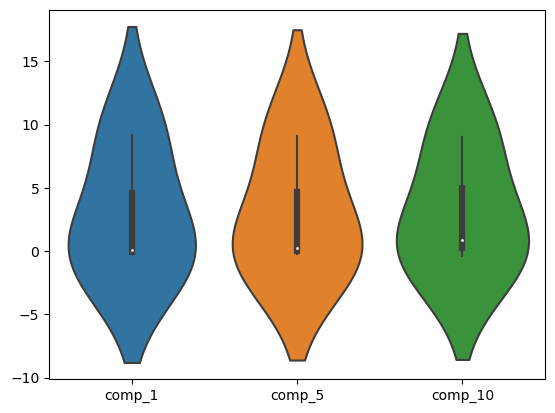

In [73]:
vis_clusters.violin_plot()

### chainlink data set, (12 x 18) SOM

In [74]:
idata_chainlink = SOMToolBox_Parse("datasets\\chainlink\\chainlink.vec").read_weight_file()
weights_chainlink = SOMToolBox_Parse("datasets\\chainlink\\chainlink.wgt.gz").read_weight_file()

In [75]:
vis_chainlink = SomAttributeDistributions(weights_chainlink['arr'], ['comp_1', 'comp_2', 'comp_3'], weights_chainlink['xdim'], weights_chainlink['ydim'])

In [76]:
#myvis.select_attributes(['comp_1', 'comp_2'])

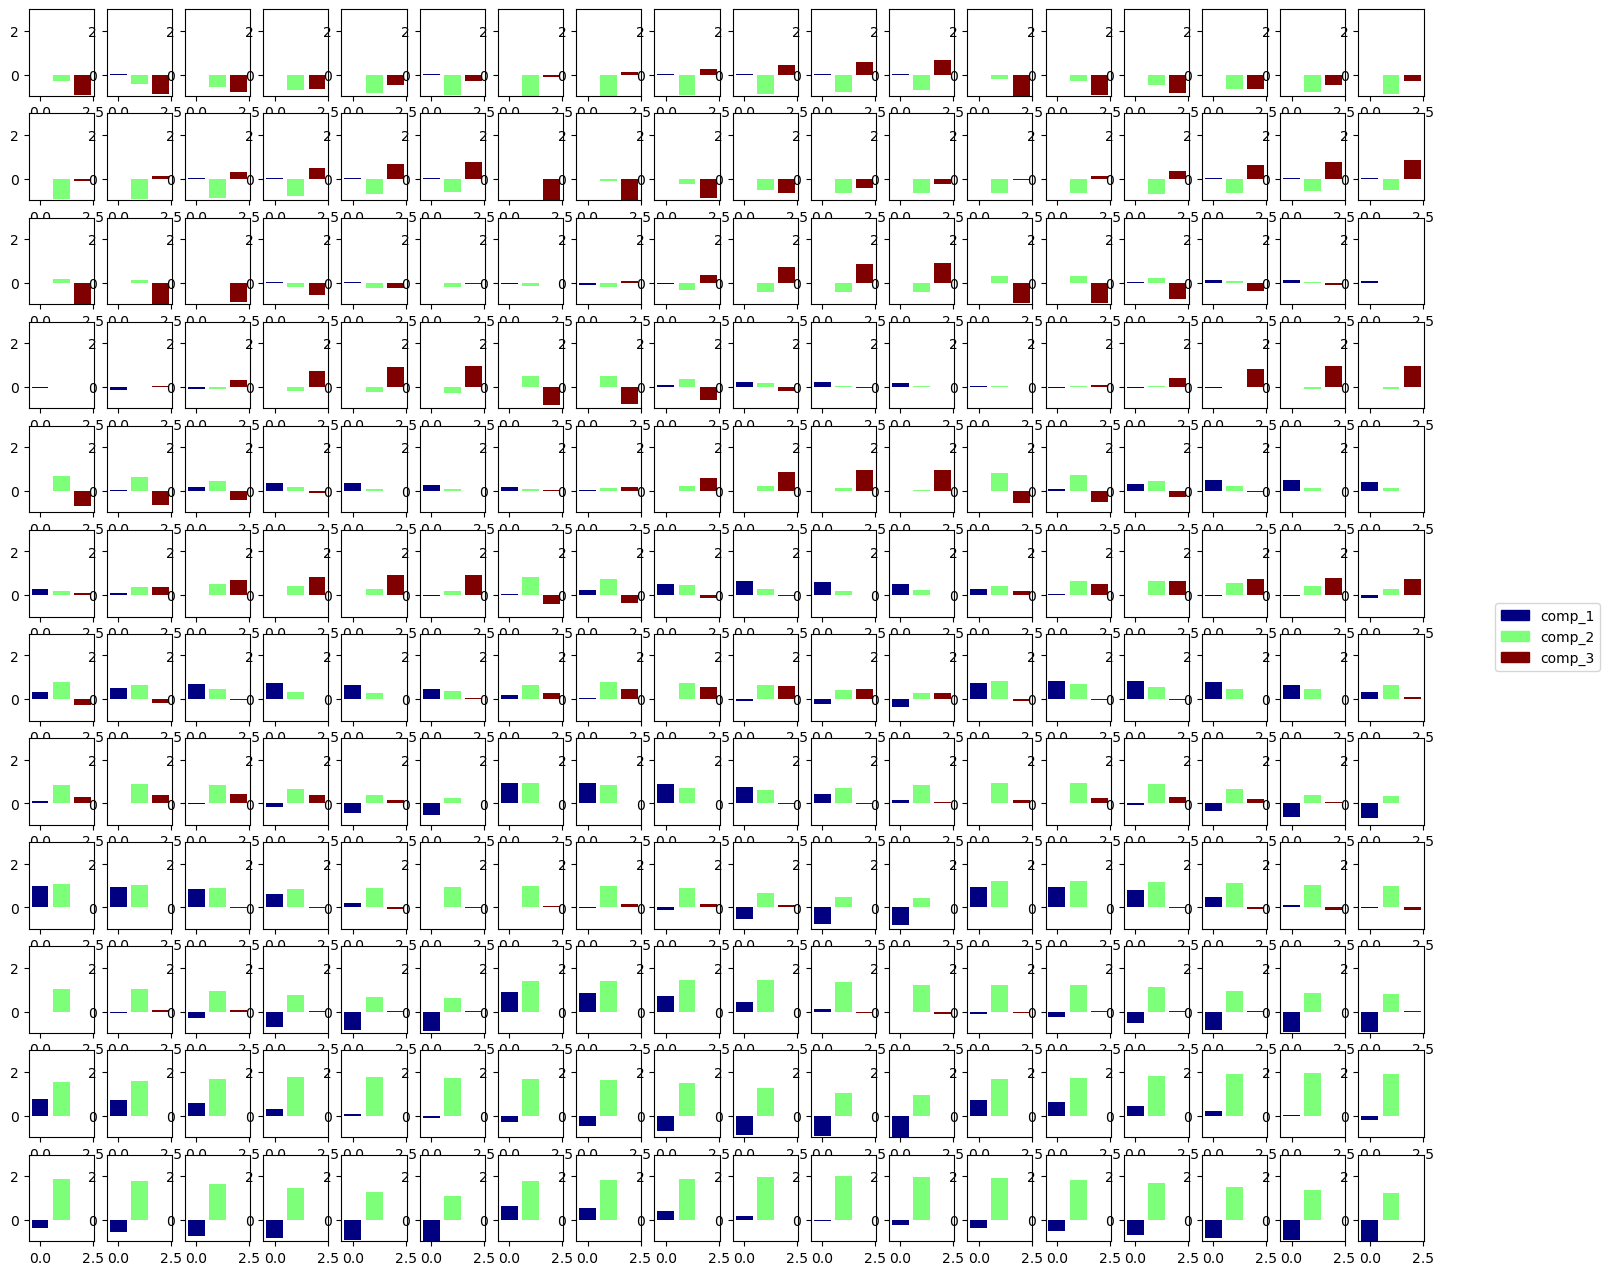

In [77]:
vis_chainlink.bar_chart()

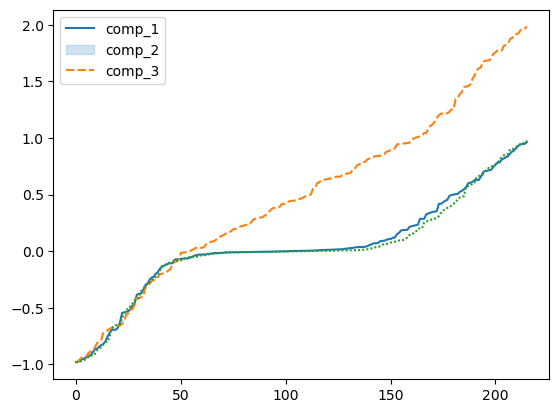

In [78]:
vis_chainlink.line_plot()

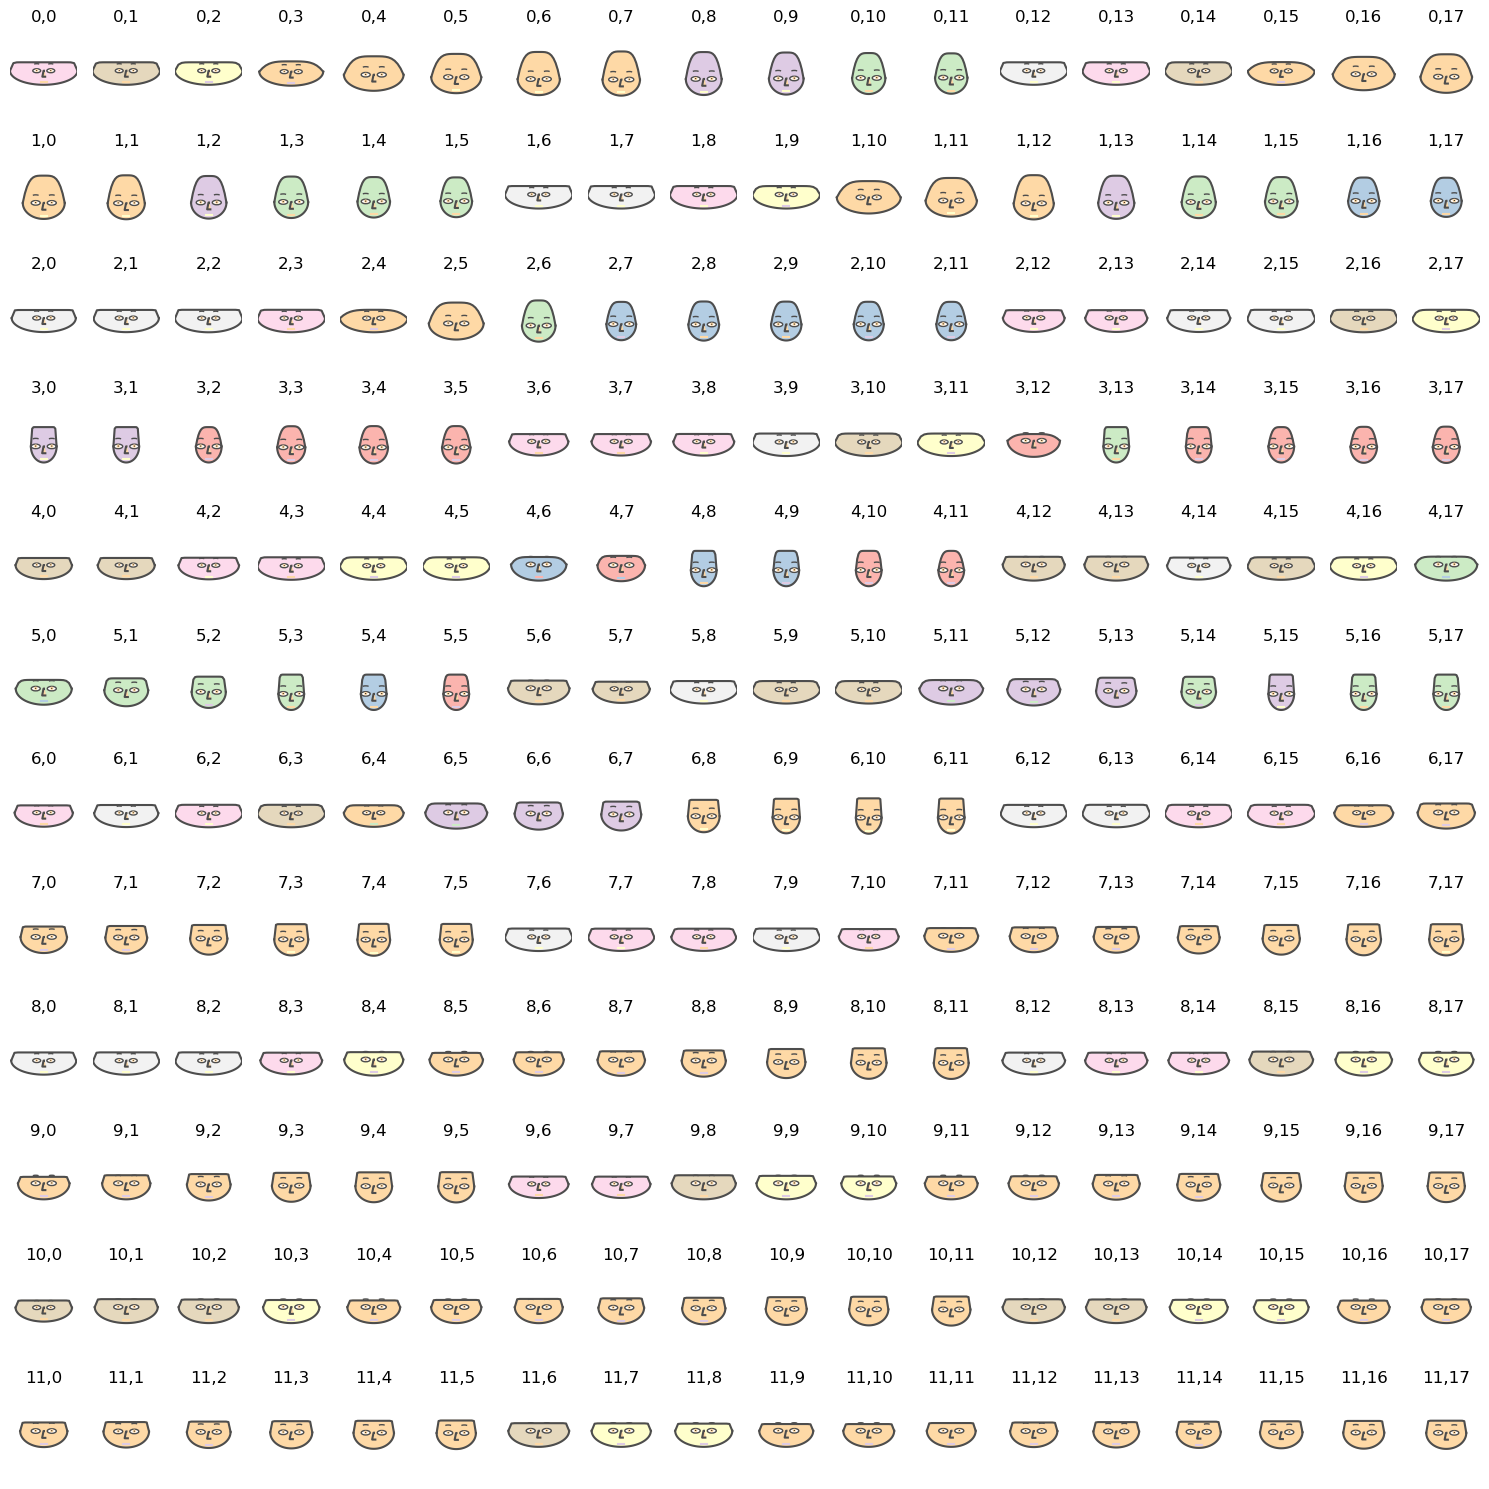

In [79]:
vis_chainlink.chernoff_faces()

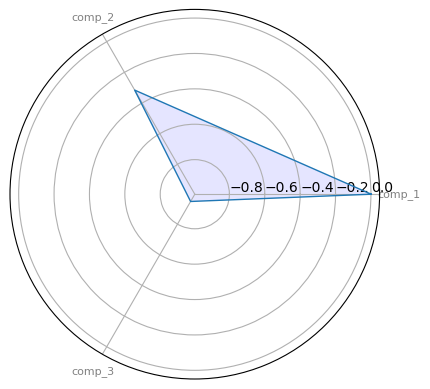

In [80]:
vis_chainlink.radar_chart()

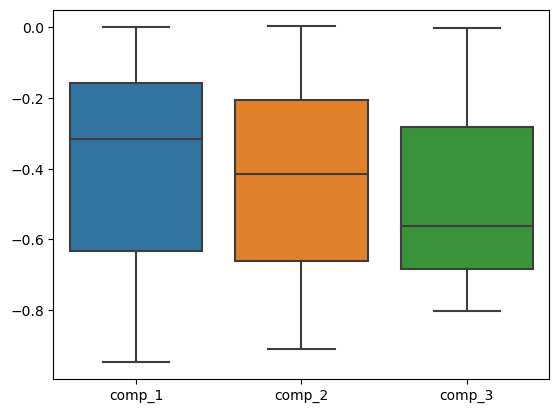

In [81]:
vis_chainlink.box_plot()

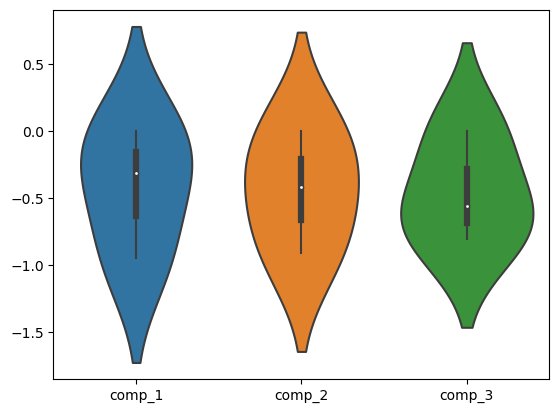

In [82]:
vis_chainlink.violin_plot()

### Iris data set, (100 x 60) SOM

In [83]:
from minisom import MiniSom

Train the SOM of the desired size

In [84]:
som_iris_large = MiniSom(100, 60, 4)
som_iris_large.train(idata_iris['arr'], 10_000)

Reshape the data into the required shape for the visualizations

In [85]:
vis_iris_large = SomAttributeDistributions(som_iris_large._weights.reshape(6000, 4), ['sep_length', 'sep_width', 'pet_length', 'pet_width'], 100, 60)

Plots of bar charts and chernoff faces for a very large SOM have a long runtime and the results don't make much sense when trying to visualize so many units. We've therefore omitted these plots.

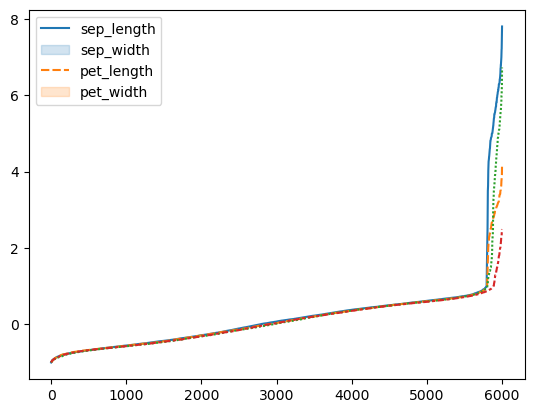

In [86]:
vis_iris_large.line_plot()

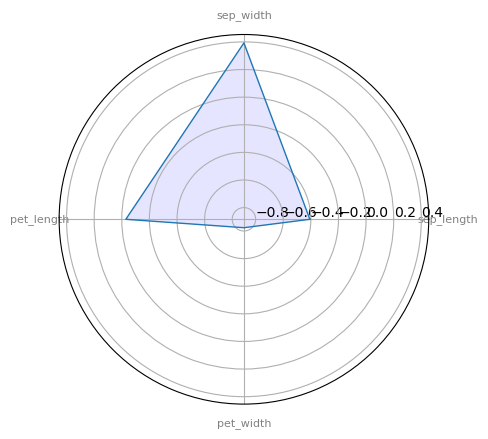

In [87]:
vis_iris_large.radar_chart()

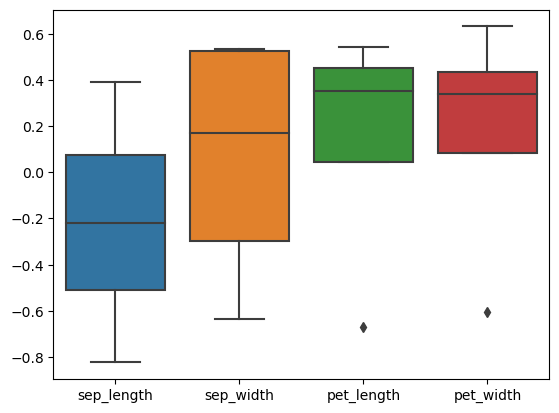

In [88]:
vis_iris_large.box_plot()

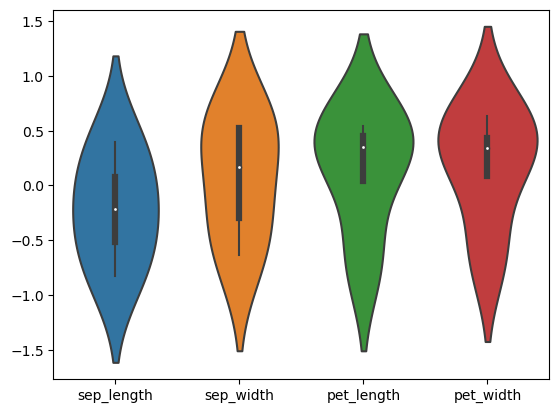

In [89]:
vis_iris_large.violin_plot()

### 10clusters data set, (100 x 60) SOM

In [90]:
som_clusters_large = MiniSom(100, 60, 10)
som_clusters_large.train(idata_clusters['arr'], 10_000)

In [91]:
vis_clusters_large = SomAttributeDistributions(som_clusters_large._weights.reshape(6000, 10), [f'comp_{i}' for i in range(1, 11)], 100, 60)

In [92]:
vis_clusters_large.select_attributes(['comp_1', 'comp_2', 'comp_3'])

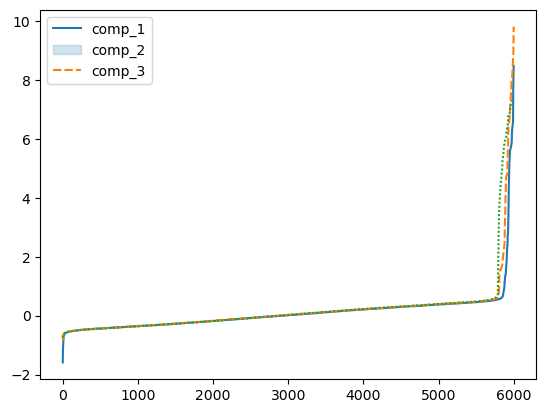

In [93]:
vis_clusters_large.line_plot()

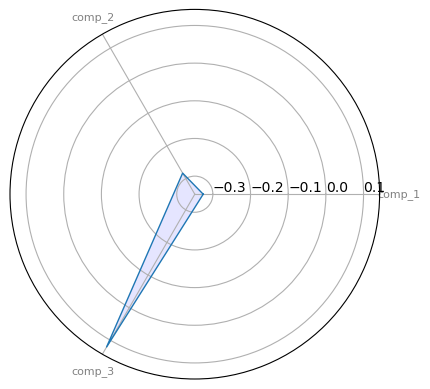

In [94]:
vis_clusters_large.radar_chart()

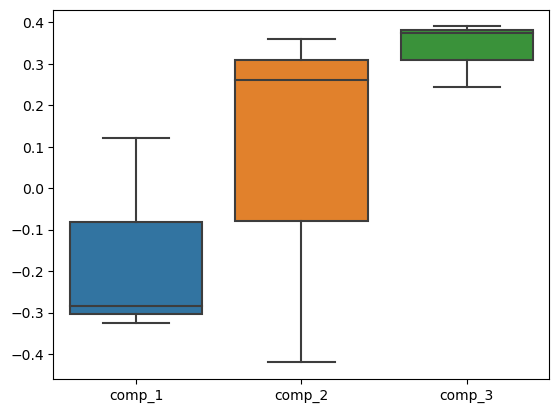

In [95]:
vis_clusters_large.box_plot()

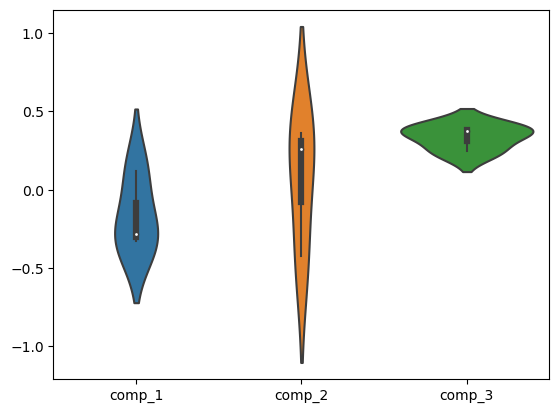

In [96]:
vis_clusters_large.violin_plot()

### chainlink data set, (100 x 60) SOM

In [97]:
som_chainlink_large = MiniSom(100, 60, 3)
som_chainlink_large.train(idata_chainlink['arr'], 10_000)

In [98]:
vis_chainlink_large = SomAttributeDistributions(som_chainlink_large._weights.reshape(6000, 3), ['comp_1', 'comp_2', 'comp_3'], 100, 60)

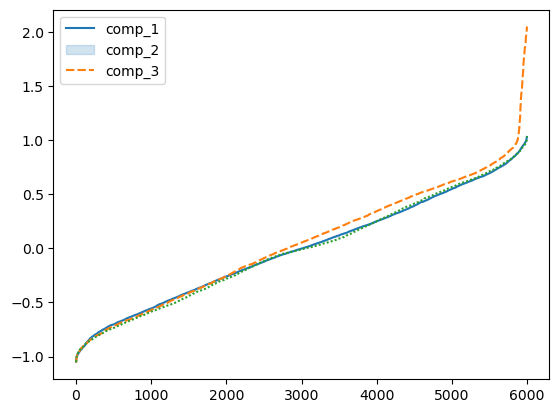

In [99]:
vis_chainlink_large.line_plot()

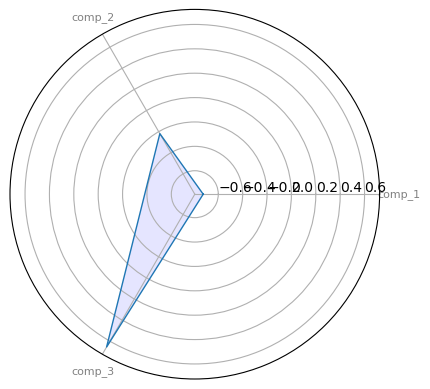

In [100]:
vis_chainlink_large.radar_chart()

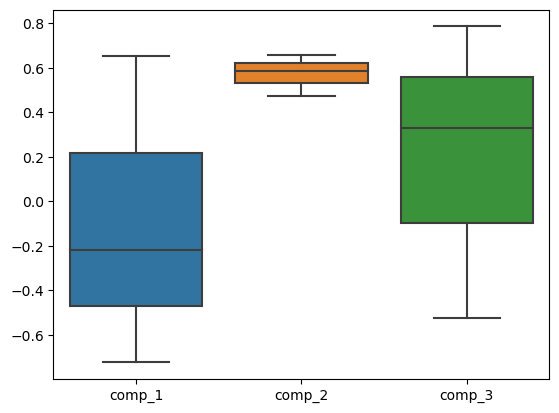

In [101]:
vis_chainlink_large.box_plot()

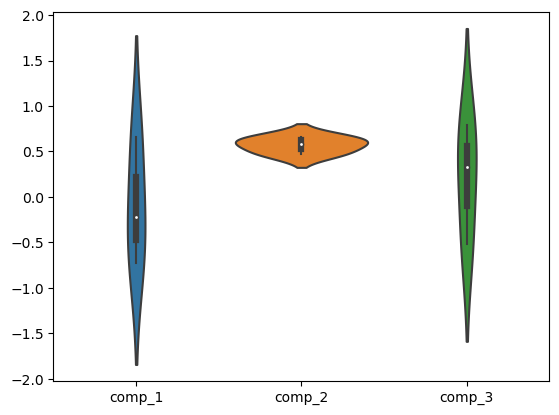

In [102]:
vis_chainlink_large.violin_plot()